# Inclusión de variables categóricas en los modelos

Por último analizaremos el impacto de incluir variables categóricas en nuestros modelos.

Esta es una pregunta bastante común en problemas de modelado. ¿Qué tanto cambia el resultado a través de diferentes categorías?
Las categorías son variables discretas sin un orden específico. Por ejemplo:

- Sexo: masculino, femenino.
- Continente: América, Asia, África.
- Universidad: ITESO, Tecnológico de Monterrey, UDG.

Hay que tener cuidado, ya que en muchos contextos, este tipo de variables se codifican como variables numéricas (one-hot encoding, label encoding, entre otros) y se suelen tratar en los modelos como variables continuas, lo cual puede llevar a conclusiones incorrectas.

Una idea un poco menos común es que los parámetros del modelo dependan de las categorías. En este caso, podríamos decir que desarrollamos un modelo por cada categoría. De esta forma, no se sufren de los problemas antes mencionados, y es lo que estudiaremos en este cuaderno.

Usaremos todo lo que vimos en el cuaderno anterior:

In [1]:
# Importar pandas
import pandas as pd
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az
# Importar numpy
import numpy as np
# Importar train_test_split
from sklearn.model_selection import train_test_split
# Importamos precision_recall_curve y f1_score
from sklearn.metrics import precision_recall_curve, f1_score
# Importamos pyplot
import matplotlib.pyplot as plt
# Importamos seaborn
import seaborn as sns

c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\arviz\data\base.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# Leer el archivo de datos (bank.csv)
bank_data = pd.read_csv("data/bank.csv")
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# Versión numérica de la columna "deposit"
bank_data['deposit_num'] = bank_data['deposit'].map({'yes': 1, 'no': 0})

In [5]:
# Normalización de las columnas numéricas
num_cols = ['balance', 'pdays', 'previous']
for col in num_cols:
    mean = bank_data[col].mean()
    std = bank_data[col].std()
    bank_data[f'{col}_std'] = (bank_data[col] - mean) / std

In [6]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,deposit,deposit_num,balance_std,pdays_std,previous_std
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,...,1042,1,-1,0,unknown,yes,1,0.252514,-0.481162,-0.363244
1,56,admin.,married,secondary,no,45,no,no,unknown,5,...,1467,1,-1,0,unknown,yes,1,-0.459953,-0.481162,-0.363244
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,...,1389,1,-1,0,unknown,yes,1,-0.080157,-0.481162,-0.363244
3,55,services,married,secondary,no,2476,yes,no,unknown,5,...,579,1,-1,0,unknown,yes,1,0.293749,-0.481162,-0.363244
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,...,673,2,-1,0,unknown,yes,1,-0.416858,-0.481162,-0.363244


Utilizaremos solo una variable categórica correspondiente a:

housing: tiene préstamo hipotecario? (categórica: 'no', 'yes')

Para esto la codificamos primero:

In [7]:
# Versión numérica de la columna housing
bank_data['housing_num'] = bank_data['housing'].map({'yes': 1, 'no': 0})

El modelo seguirá siendo básicamente el mismo, nada más que $\alpha$ dependerá de la variable poutcome.

$$
\begin{align}
\begin{array}{lcl}
deposit_i & \sim & \text{Bernoulli}(p_i) \\
\text{logit}(p_i) & = & \alpha_{HOUSING[i]} + \beta_{balance}balance_i + \beta_{pdays}pdays_i + \beta_{previous}previous_i \\
\alpha_j & \sim & \text{Normal}(0, 1) \qquad \text{for } j=0,1\\
\beta_{balance} & \sim & \text{Normal}(0, 1) \\
\beta_{pdays} & \sim & \text{Normal}(0, 1) \\
\beta_{previous} & \sim & \text{Normal}(0, 1) \\
\end{array}
\end{align}
$$

In [10]:
# Partición de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    bank_data[["balance_std", "pdays_std", "previous_std", "housing_num"]],
    bank_data["deposit_num"],
    test_size=0.2,
    random_state=42
)

In [64]:
# Redefinimos modelo con variables mutables
balance = X_train["balance_std"].values
pdays = X_train["pdays_std"].values
previous = X_train["previous_std"].values
housing = X_train["housing_num"].values
deposit = y_train.values
coords = {
    "housing_dim": np.arange(2)
}
with pm.Model(coords=coords) as only_num_model:
    # Variables numéricas mutables
    balance = pm.MutableData("balance", balance, dims="obs")
    pdays = pm.MutableData("pdays", pdays, dims="obs")
    previous = pm.MutableData("previous", previous, dims="obs")
    deposit = pm.MutableData("deposit_data", deposit, dims="obs")
    housing = pm.MutableData("housing", housing, dims="obs")
    # Previas
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="housing_dim")
    beta_balance = pm.Normal("beta_balance", mu=0, sigma=1)
    beta_pdays = pm.Normal("beta_pdays", mu=0, sigma=1)
    beta_previous = pm.Normal("beta_previous", mu=0, sigma=1)
    # Regresión
    p = pm.Deterministic(
        "p", 
        pm.invlogit(
            alpha[housing]
            + beta_balance * balance
            + beta_pdays * pdays
            + beta_previous * previous
        ),
        dims="obs"
    )
    # Deposit
    deposit = pm.Bernoulli("deposit", p=p, observed=deposit, dims="obs")
    # Muestra posterior
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_balance, beta_pdays, beta_previous]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


array([<Axes: title={'center': 'beta_balance'}>,
       <Axes: title={'center': 'beta_pdays'}>,
       <Axes: title={'center': 'beta_previous'}>], dtype=object)

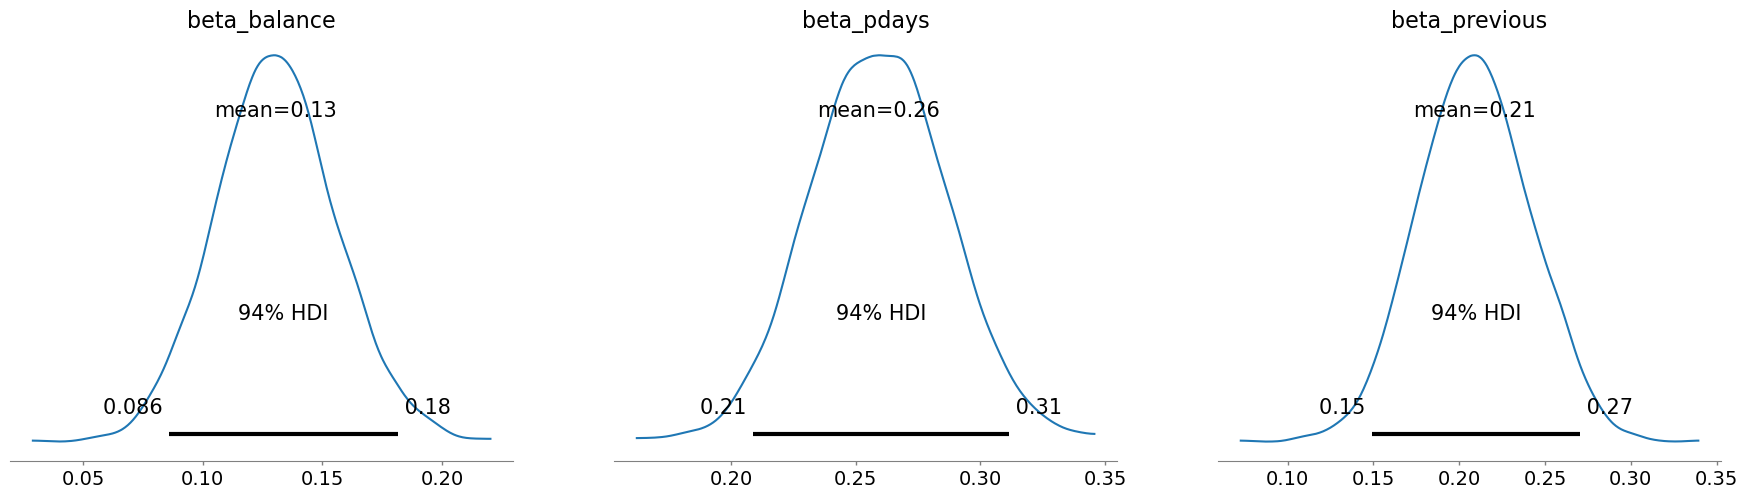

In [65]:
# az.plot_posterior
az.plot_posterior(idata, var_names=["beta_balance", "beta_pdays", "beta_previous"])

### Conclusión:

- Todas las variables siguen teniendo un impacto positivo en el objetivo. Sin embargo:
  - balance: tiene un impacto menor que cuando el modelo no consideraba housing.
  - pdays: tiene un impacto mayor que cuando el modelo no consideraba housing.
  - previous: tiene un impacto similar.

In [66]:
# Importar scipy.special.expit as logistic
from scipy.special import expit as logistic

array([<Axes: title={'center': 'alpha\n0'}>,
       <Axes: title={'center': 'alpha\n1'}>], dtype=object)

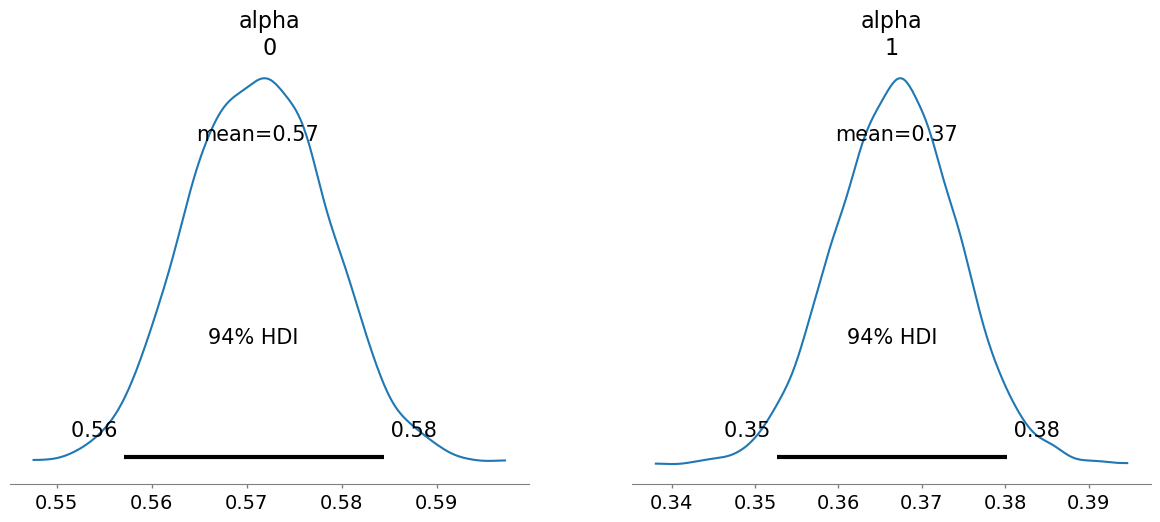

In [67]:
# Plot posterior
az.plot_posterior(idata, var_names=[ "alpha"], transform=logistic)

<Axes: title={'center': 'x'}>

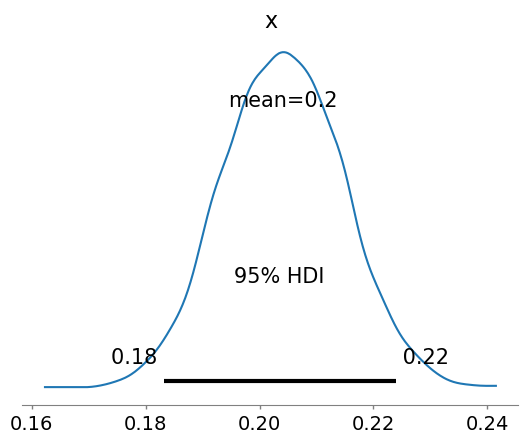

In [68]:
alpha0 = idata.posterior["alpha"].sel(housing_dim=0).values.flatten()
alpha1 = idata.posterior["alpha"].sel(housing_dim=1).values.flatten()
alpha0_transformed = logistic(alpha0)
alpha1_transformed = logistic(alpha1)
diff_alpha = alpha0_transformed - alpha1_transformed
az.plot_posterior(diff_alpha, hdi_prob=0.95)

### Conclusión:
- Observamos que la probabilidad de aceptar un depósito de un sujeto promedio cuando **no tiene crédito hipotecario**, es considerablemente mayor que cuando sí lo tiene.

In [69]:
# Cambiamos los datos observados y muestreamos la distribución posterior predictiva
with only_num_model:
    pm.set_data({
        "balance": X_test["balance_std"].values,
        "pdays": X_test["pdays_std"].values,
        "previous": X_test["previous_std"].values,
        "housing": X_test["housing_num"].values,
        "deposit_data": y_test.values
    }, coords={"obs": X_test.index.values})
    ppc = pm.sample_posterior_predictive(idata, var_names=["deposit"])

Sampling: [deposit]


In [70]:
# Tomamos promedio sobre las cadenas y las muestras
y_scores = ppc.posterior_predictive["deposit"].mean(dim=["chain", "draw"])
y_scores

<xarray.DataArray 'deposit' (obs: 2233)> Size: 18kB
array([0.5095 , 0.50925, 0.54625, ..., 0.5235 , 0.80675, 0.65375])
Coordinates:
  * obs      (obs) int64 18kB 5527 4541 1964 5007 8928 ... 5544 10749 3881 6786

In [71]:
# Construimos la curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_scores)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

In [72]:
# Construimos la curva F1 vs. umbrales
f1 = pd.Series({t: f1_score(y_true=y_test, y_pred=y_scores > t) for t in thresholds})
# Encontramos el umbral que maximiza F1
best_threshold = f1.idxmax()

In [73]:
pr_curve.loc[np.where(thresholds == best_threshold)]

,Precision,Recall
164,0.568288,0.799438


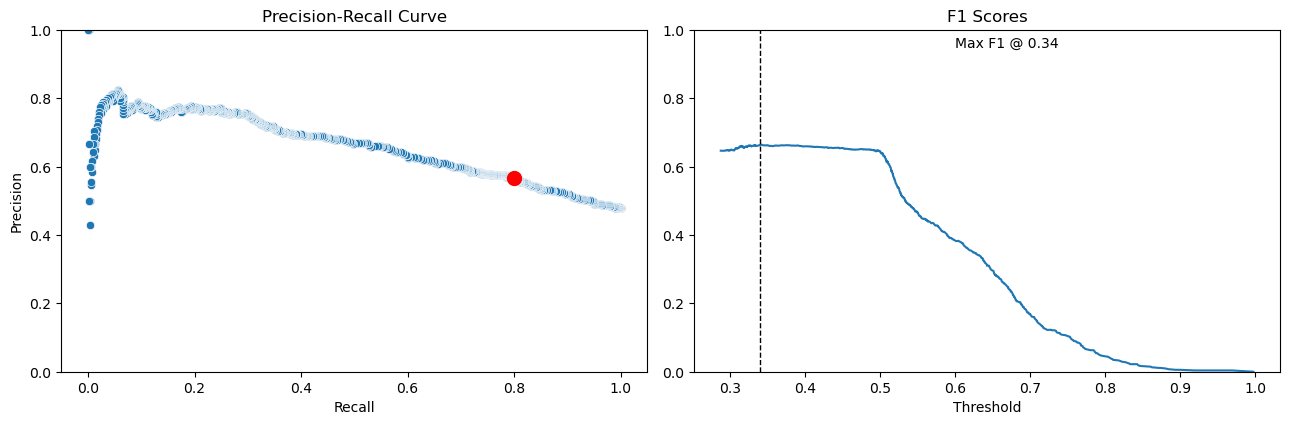

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))

# Curva Precision-Recall, con el mejor umbral marcado
sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[0])
axes[0].plot(
    pr_curve.loc[np.where(thresholds == best_threshold)[0], 'Recall'],
    pr_curve.loc[np.where(thresholds == best_threshold)[0], 'Precision'],
    'ro',
    ms=10
)
axes[0].set_ylim(0,1)
axes[0].set_title('Precision-Recall Curve')

# Curva F1 vs. umbrales, con el mejor umbral marcado
f1.plot(ax=axes[1], title='F1 Scores', ylim=(0,1))
axes[1].set_xlabel('Threshold')
axes[1].axvline(best_threshold, lw=1, ls='--', color='k')
axes[1].text(x=.60, y=.95, s=f'Max F1 @ {best_threshold:.2f}')
fig.tight_layout()
plt.subplots_adjust(top=.8)
plt.show();

In [75]:
# Accuracy
(y_test == (y_scores > best_threshold)).mean()

0.6144200626959248

### Conclusión:

Incluir la variable categórica "housing" mejoró significativamente la capacidad predictiva de nuestro modelo.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>